##  First we need to check which of the foot taffic senors work

In [3]:
import requests

response = requests.get(f'https://data.melbourne.vic.gov.au/api/records/1.0/search/?dataset=pedestrian-counting-system-past-hour-counts-per-minute&q=&rows=1000&sort=sensingdatetime&facet=locationid&facet=sensingdatetime')

data = response.json()

ID = []

for record in data['records']:
    ID.append(record['fields']['locationid'])

ID = sorted(set(ID))

print(ID)

[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 17, 18, 19, 20, 23, 24, 26, 27, 28, 29, 30, 31, 35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 84, 85, 86, 87, 107, 117, 118]


## Next I need to find the closet working camera to the MCG 

In [4]:
import math
import requests

table1 = []
 
a = -37.81986511309929, 144.9834707379584

table1.append(a)

response = requests.get('https://data.melbourne.vic.gov.au/api/records/1.0/search/?dataset=pedestrian-counting-system-sensor-locations&q=&rows=200&facet=installation_date&facet=status&facet=direction_1&facet=direction_2&facet=Location')

data = response.json()

table2 = []

for item in data['records']:
    table2.append(item['fields']['location'])

def distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371 
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c  
    return d
total_directions = []

distances = []
for coord1 in table1:
    for coord2 in table2:
        d = distance(coord1, coord2)
        distances.append((d, coord1, coord2))

distances.sort()

for i in range(7):
    print(f"Closest match {i+1}: Distance {distances[i][0]:.2f}km, Coordinates {distances[i][1]}, {distances[i][2]}")
    
response = requests.get('https://data.melbourne.vic.gov.au/api/records/1.0/search/?dataset=pedestrian-counting-system-sensor-locations&q=&rows=200&facet=installation_date&facet=status&facet=direction_1&facet=direction_2')

data = response.json()

for i in range(7):
    for record in data['records']:
        sensing_datetime = record['fields']['location']
        total_directions = record['fields']['location_id']
        if distances[i][2] == sensing_datetime:
            print(f"Match{i+1}: {total_directions}")

Closest match 1: Distance 0.60km, Coordinates (-37.81986511309929, 144.9834707379584), [-37.81498411, 144.98638807]
Closest match 2: Distance 0.66km, Coordinates (-37.81986511309929, 144.9834707379584), [-37.81499687, 144.97925064]
Closest match 3: Distance 0.66km, Coordinates (-37.81986511309929, 144.9834707379584), [-37.81493732, 144.97932442]
Closest match 4: Distance 0.67km, Coordinates (-37.81986511309929, 144.9834707379584), [-37.81488315, 144.97926569]
Closest match 5: Distance 0.68km, Coordinates (-37.81986511309929, 144.9834707379584), [-37.82102867, 144.97590204]
Closest match 6: Distance 0.78km, Coordinates (-37.81986511309929, 144.9834707379584), [-37.81303095, 144.98124662]
Closest match 7: Distance 0.93km, Coordinates (-37.81986511309929, 144.9834707379584), [-37.81515276, 144.97467661]
Match1: 93
Match2: 96
Match3: 116
Match4: 95
Match5: 110
Match6: 94
Match7: 75


## The closet working camera is 75 and I need to look at its location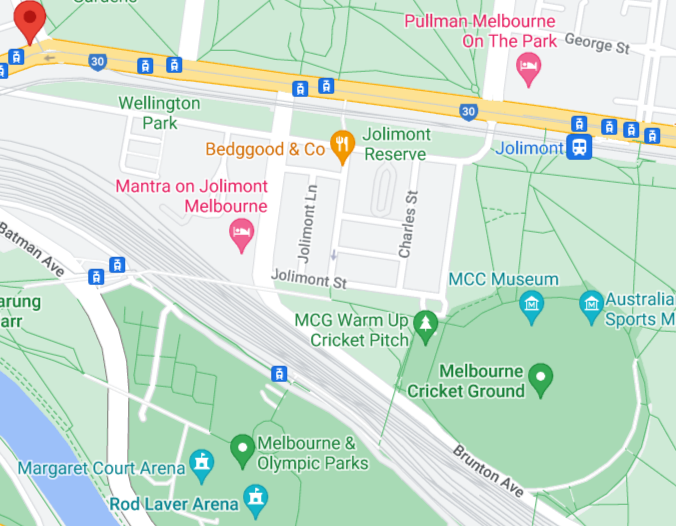  this location seems close enough to track the foot traffic increase.

## Next I need to create a CSV file with the date so I can recreate the Graph.

In [5]:
import csv
import requests

location_id = '75'

response = requests.get(f'https://data.melbourne.vic.gov.au/api/records/1.0/search/?dataset=pedestrian-counting-system-past-hour-counts-per-minute&q=&rows=9999&sort=sensingdatetime&facet=locationid&facet=sensingdatetime&refine.locationid={location_id}')

data = response.json()


data_list = []

for record in data['records']:
    sensing_date = record['fields']['sensingdate']
    sensing_time = record['fields']['sensingtime']
    total_directions = str(record['fields']['total_of_directions'])
    data = sensing_date + ',' + sensing_time + ',' + total_directions
    data_list.append([sensing_date, sensing_time, total_directions])

with open('senor_75.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Date', 'Time', 'Total'])
    writer.writerows(data_list)

## Now I need to start graphing first I am going to graph the total foot traffic each day

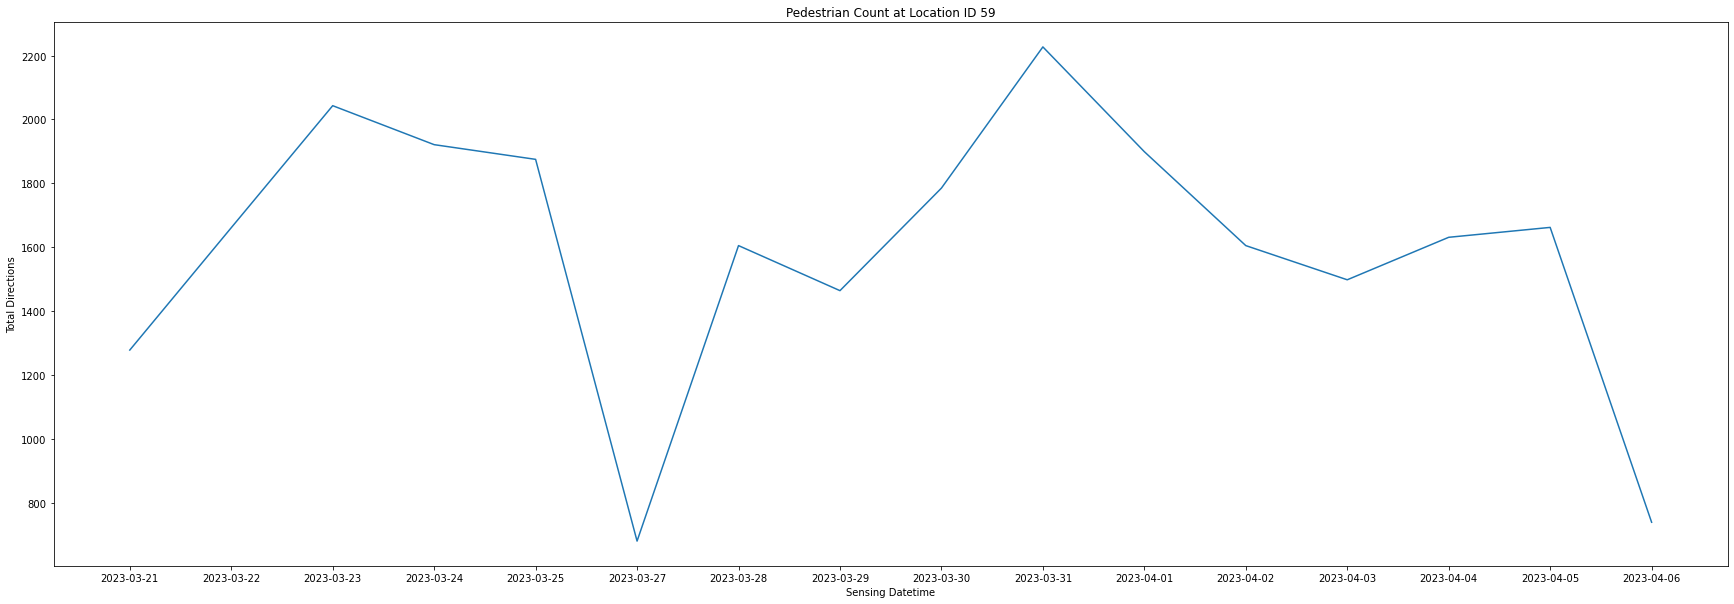

In [10]:
import requests
import matplotlib.pyplot as plt

location_id = '75'

response = requests.get(f'https://data.melbourne.vic.gov.au/api/records/1.0/search/?dataset=pedestrian-counting-system-past-hour-counts-per-minute&q=&rows=9999&sort=sensingdatetime&facet=locationid&facet=sensingdatetime&refine.locationid={location_id}')

data = response.json()

sensing_datetime_list = []
total_directions_list = []
prevois_date_lsit = 0
day_total = 0

for record in data['records']:
    sensing_datetime = record['fields']['sensingdate']
    total_directions = record['fields']['total_of_directions']

    
    if prevois_date_lsit == sensing_datetime:
        day_total += total_directions
    else:
        total_directions_list.append(day_total)
        sensing_datetime_list.append(prevois_date_lsit)
        day_total = 0
    prevois_date_lsit = sensing_datetime
    
sensing_datetime_list.pop(0)
total_directions_list.pop(0)

sensing_datetime_list.reverse()
total_directions_list.reverse()

fig, ax = plt.subplots(figsize=(30, 10)) 
ax.plot(sensing_datetime_list, total_directions_list)
ax.set_xlabel('Sensing Datetime')
ax.set_ylabel('Total Directions')
ax.set_title('Pedestrian Count at Location ID 75')
plt.show()


## This graph shows that there are spikes on the 22/03/23 and the 31/3/23 these directly relate to AFL games where both team are from or near melbourne  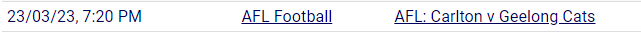  


## 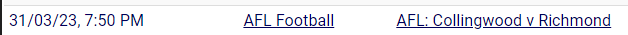This shows that the foot traffic was increasted by these live events. 

## Next I am going to look at just the 31/03/23 since it is the largest spike

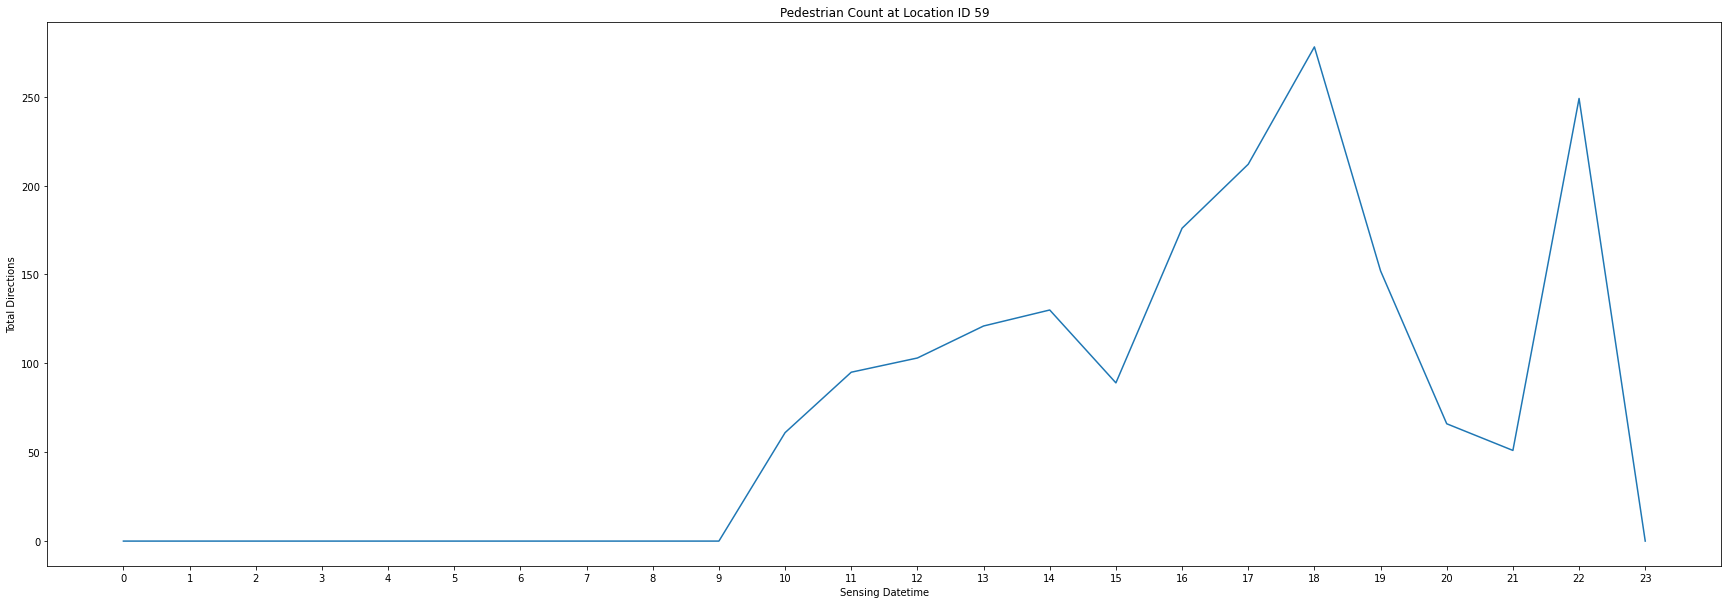

In [9]:
import requests
import matplotlib.pyplot as plt

location_id = '75'

response = requests.get(f'https://data.melbourne.vic.gov.au/api/records/1.0/search/?dataset=pedestrian-counting-system-past-hour-counts-per-minute&q=&rows=9999&sort=sensingdatetime&facet=locationid&facet=sensingdatetime&refine.locationid={location_id}')

data = response.json()


sensing_datetime_list = ["0", "1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23"]
total_directions_list = []
prevois_date_lsit = ('2023-03-23')
total_hour_0 = 0
total_hour_1 = 0
total_hour_2 = 0
total_hour_3 = 0
total_hour_4 = 0
total_hour_5 = 0
total_hour_6 = 0
total_hour_7 = 0
total_hour_8 = 0
total_hour_9 = 0
total_hour_10 = 0
total_hour_11 = 0
total_hour_12 = 0
total_hour_13 = 0
total_hour_14 = 0
total_hour_15 = 0
total_hour_16 = 0
total_hour_17 = 0
total_hour_18 = 0
total_hour_19 = 0
total_hour_20 = 0
total_hour_21 = 0
total_hour_22 = 0
total_hour_23 = 0

for record in data['records']:
    sensing_date = record['fields']['sensingdate']
    total_directions = record['fields']['total_of_directions']
    if prevois_date_lsit == sensing_date:
        sensing_datetime = record['fields']['sensingtime']
        substrings = sensing_datetime.split(":")
        if substrings[0] == ("0"):
            total_hour_0 += total_directions
        elif substrings[0] == ("1"):
            total_hour_1 += total_directions
        elif substrings[0] == ("2"):
            total_hour_2 += total_directions
        elif substrings[0] == ("3"):
            total_hour_3 += total_directions
        elif substrings[0] == ("4"):
            total_hour_4 += total_directions
        elif substrings[0] == ("5"):
            total_hour_5 += total_directions
        elif substrings[0] == ("6"):
            total_hour_6 += total_directions
        elif substrings[0] == ("7"):
            total_hour_7 += total_directions
        elif substrings[0] == ("8"):
            total_hour_8 += total_directions
        elif substrings[0] == ("9"):
            total_hour_9 += total_directions
        elif substrings[0] == ("10"):
            total_hour_10 += total_directions
        elif substrings[0] == ("11"):
            total_hour_11 += total_directions
        elif substrings[0] == ("12"):
            total_hour_12 += total_directions
        elif substrings[0] == ("13"):
            total_hour_13 += total_directions
        elif substrings[0] == ("14"):
            total_hour_14 += total_directions
        elif substrings[0] == ("15"):
            total_hour_15 += total_directions
        elif substrings[0] == ("16"):
            total_hour_16 += total_directions
        elif substrings[0] == ("17"):
            total_hour_17 += total_directions
        elif substrings[0] == ("18"):
            total_hour_18 += total_directions
        elif substrings[0] == ("19"):
            total_hour_19 += total_directions
        elif substrings[0] == ("20"):
            total_hour_20 += total_directions
        elif substrings[0] == ("21"):
            total_hour_21 += total_directions
        elif substrings[0] == ("22"):
            total_hour_22 += total_directions
        elif substrings[0] == ("23"):
            total_hour_23 += total_directions

total_directions_list.append(total_hour_0)
total_directions_list.append(total_hour_1)
total_directions_list.append(total_hour_2)
total_directions_list.append(total_hour_3)
total_directions_list.append(total_hour_4)
total_directions_list.append(total_hour_5)
total_directions_list.append(total_hour_6)
total_directions_list.append(total_hour_7)
total_directions_list.append(total_hour_8)
total_directions_list.append(total_hour_9)
total_directions_list.append(total_hour_10)
total_directions_list.append(total_hour_11)
total_directions_list.append(total_hour_12)
total_directions_list.append(total_hour_13)
total_directions_list.append(total_hour_14)
total_directions_list.append(total_hour_15)
total_directions_list.append(total_hour_16)
total_directions_list.append(total_hour_17)
total_directions_list.append(total_hour_18)
total_directions_list.append(total_hour_19)
total_directions_list.append(total_hour_20)
total_directions_list.append(total_hour_21)
total_directions_list.append(total_hour_22)
total_directions_list.append(total_hour_23)

fig, ax = plt.subplots(figsize=(30, 10)) 
ax.plot(sensing_datetime_list, total_directions_list)
ax.set_xlabel('Sensing Datetime')
ax.set_ylabel('Total Directions')
ax.set_title('Pedestrian Count at Location ID 75')
plt.show()

## This graph shows that the peaks for the day where around 5, 6 and 7 pm and 10 pm this this is because the those are the times where people were heading to the footy game that started at 7:50pm and leaving the flooty game. Also the lowest moment during the day besides the morning is was around 8 and 9 this is most likey due the the game being on at that time.

## This shows that the footy (Live event) made the foot taffic in the area go up which means the local business near by would have had more foot taffic which means more business.